In [3]:
import databento as db
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/qp/2v0dqqw110gbk64jw3vk6kn80000gn/T/ipykernel_1835/3941267105.py:5: BentoWarning: The streaming request contained one or more days which have reduced quality: 2018-10-21 (degraded), 2019-01-15 (degraded), 2019-02-22 (degraded)... See: https://databento.com/docs/api-reference-historical/metadata/metadata-get-dataset-condition
  data = client.timeseries.get_range(


(2096, 9)
                           rtype  publisher_id  instrument_id   open   high  \
ts_event                                                                      
2018-01-01 00:00:00+00:00     35             1         253894  60.20  60.28   
2018-01-02 00:00:00+00:00     35             1         253894  60.23  60.74   
2018-01-03 00:00:00+00:00     35             1         253894  60.43  61.97   
2018-01-04 00:00:00+00:00     35             1         253894  61.83  62.21   
2018-01-05 00:00:00+00:00     35             1         253894  61.94  62.04   

                             low  close  volume  symbol  
ts_event                                                 
2018-01-01 00:00:00+00:00  60.13  60.23    3380  CL.c.0  
2018-01-02 00:00:00+00:00  60.10  60.42  417607  CL.c.0  
2018-01-03 00:00:00+00:00  60.28  61.83  481647  CL.c.0  
2018-01-04 00:00:00+00:00  61.59  61.94  475012  CL.c.0  
2018-01-05 00:00:00+00:00  61.09  61.59  423435  CL.c.0  


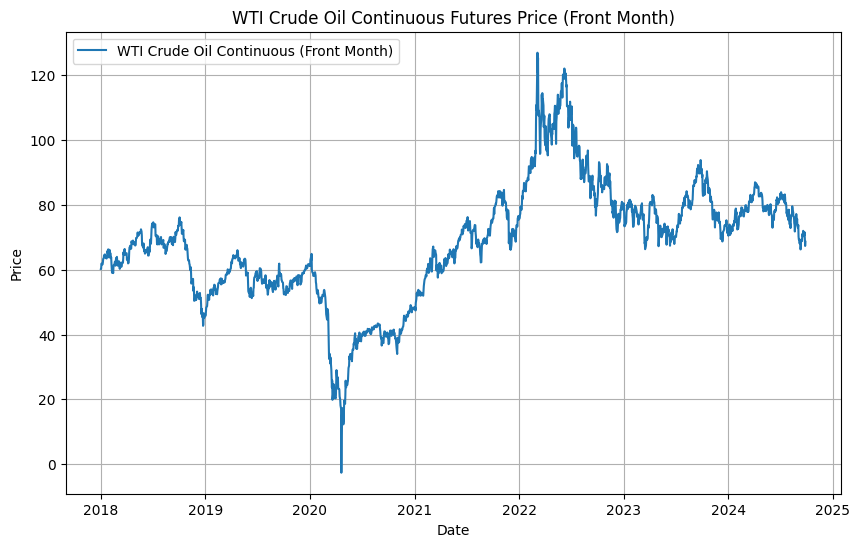

In [7]:
# Establish connection and authenticate
# client = db.Historical(key="db-HsLUpjXU6TLxiHeEATVeeyWYk5mwe")

# # Fetch continuous contract data for WTI Crude Oil Futures (front month)
# data = client.timeseries.get_range(
#     start="2018-01-01",  # Specify the start date
#     end="2024-09-28",    # Optionally, specify an end date
#     dataset="GLBX.MDP3", # The dataset for Globex futures
#     symbols=["CL.c.0"],  # WTI Crude Oil, front month continuous contract
#     stype_in="continuous",  # Specify continuous contract
#     stype_out="instrument_id",  # The type of output (instrument IDs, in this case)
#     schema="ohlcv-1d",  # OHLCV data at daily frequency
# )

# Convert the result to a DataFrame
df = data.to_df()

# Check the shape of the DataFrame (number of rows and columns)
print(df.shape)

# Print the first few rows of the DataFrame
print(df.head())

# Plot the closing prices over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['close'], label='WTI Crude Oil Continuous (Front Month)')
plt.title('WTI Crude Oil Continuous Futures Price (Front Month)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
import numpy as np

def calculate_vwap_and_deviation(df):
    # Calculate typical price
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # Calculate cumulative values for VWAP
    cumulative_volume = df['volume'].cumsum()
    cumulative_vtp = (typical_price * df['volume']).cumsum()
    
    # Calculate VWAP
    df['VWAP'] = cumulative_vtp / cumulative_volume
    
    # Calculate the cumulative variance (for standard deviation)
    cumulative_tp_squared = (typical_price**2 * df['volume']).cumsum()
    df['VWAP_Stdev'] = np.sqrt(cumulative_tp_squared / cumulative_volume - df['VWAP']**2)
    
    # Calculate upper and lower deviation bands
    df['Upper_Band'] = df['VWAP'] + df['VWAP_Stdev']
    df['Lower_Band'] = df['VWAP'] - df['VWAP_Stdev']
    
    return df

# Example usage:
# df should be a DataFrame with OHLCV data
# result_df = calculate_vwap_with_std(df)


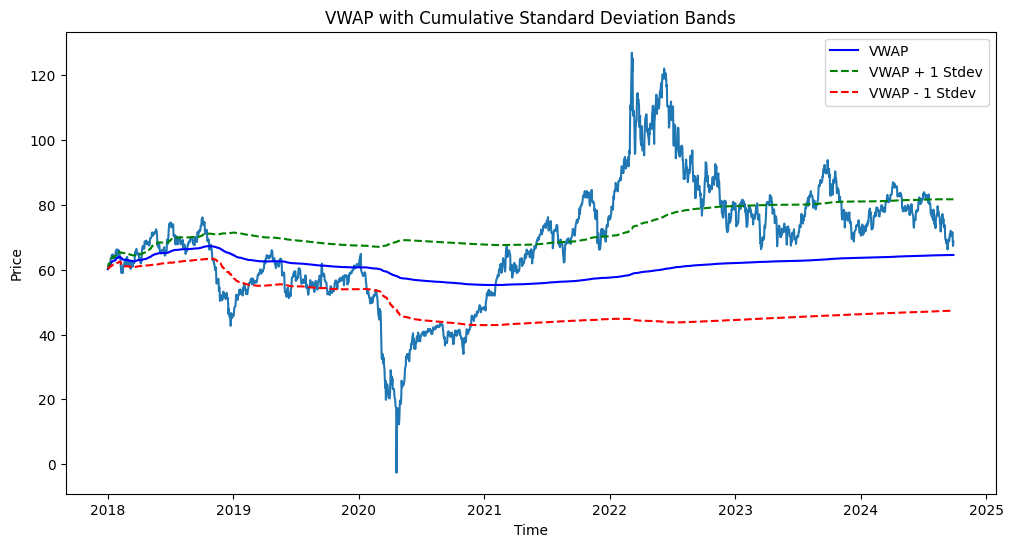

In [32]:
df_with_vwap = calculate_vwap_and_deviation(df)

# Plot VWAP and the deviation bands
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'])
plt.plot(df_with_vwap.index, df_with_vwap['VWAP'], label='VWAP', color='blue')
plt.plot(df_with_vwap.index, df_with_vwap['Upper_Band'], label='VWAP + 1 Stdev', linestyle='--', color='green')
plt.plot(df_with_vwap.index, df_with_vwap['Lower_Band'], label='VWAP - 1 Stdev', linestyle='--', color='red')

# Customize the plot
plt.title('VWAP with Cumulative Standard Deviation Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


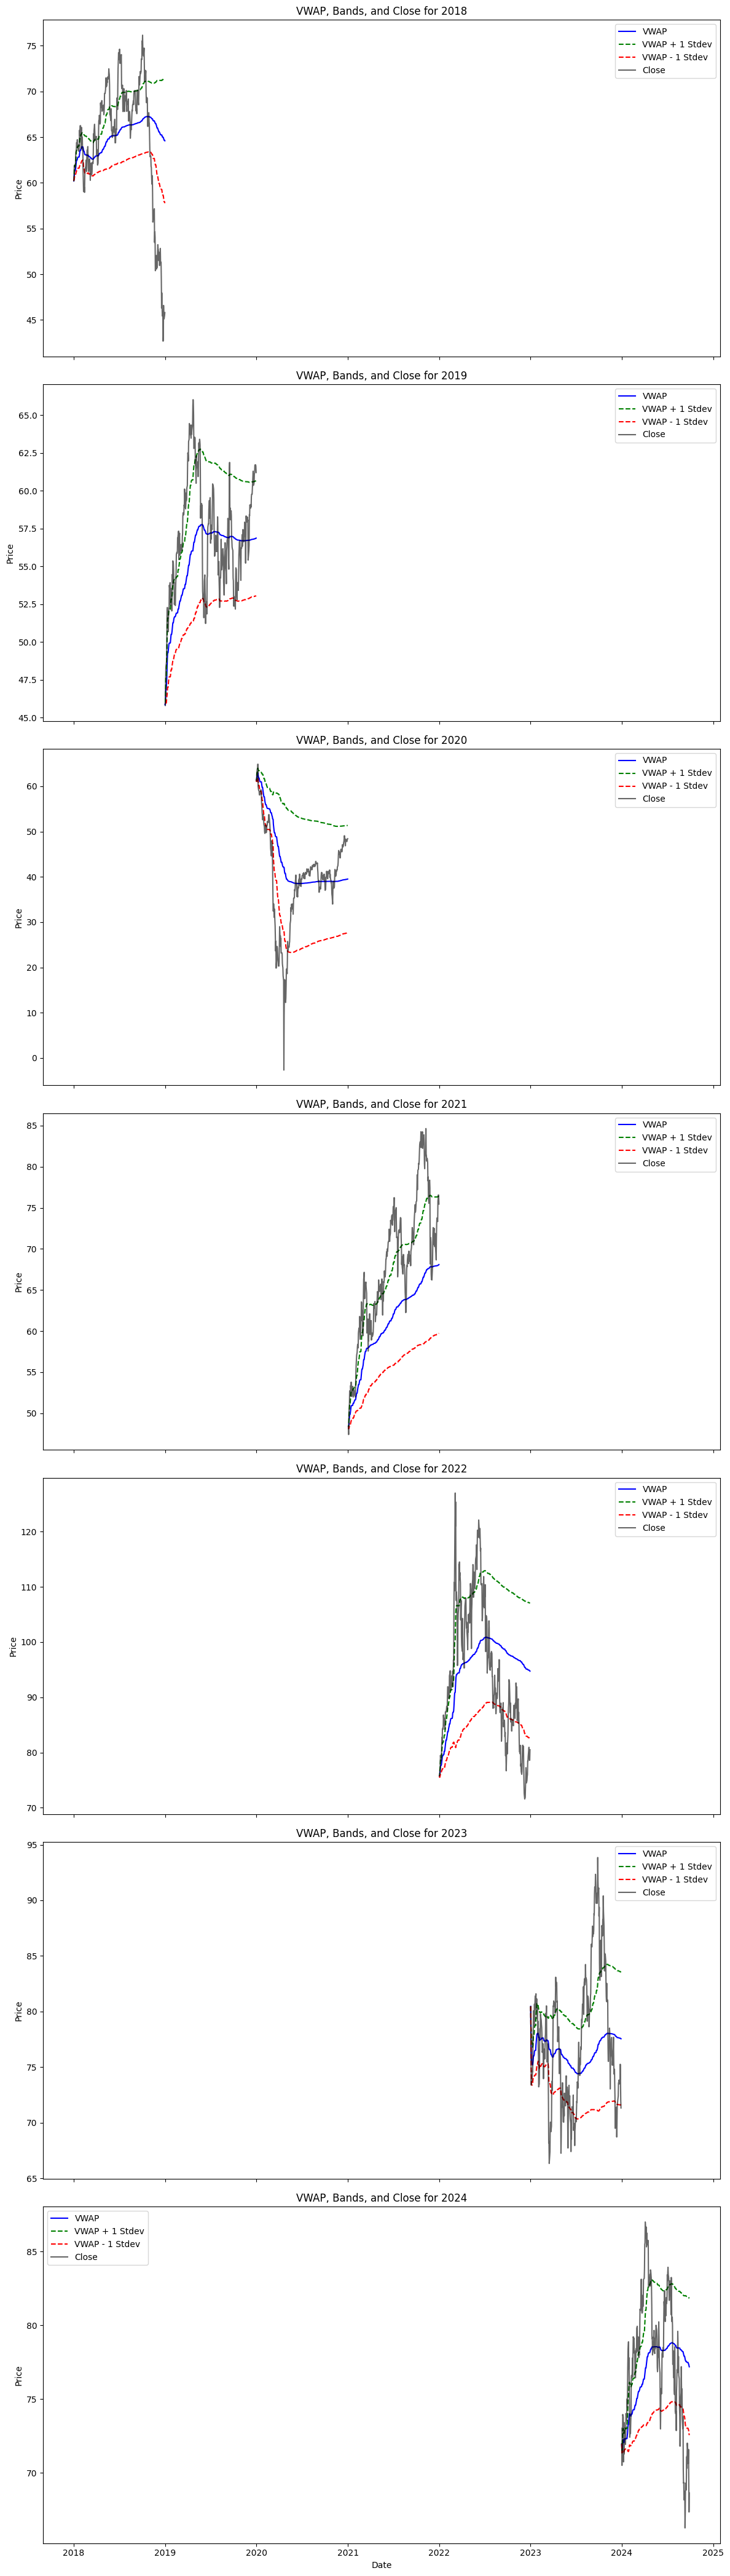

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Yearly

# Assuming your data is already loaded into a DataFrame called 'df'
# Ensure the 'ts_event' is a datetime index
df.index = pd.to_datetime(df.index)

# Add a 'year' column to group the data by year
df['year'] = df.index.year

# Group the data by year
grouped_data = df.groupby('year')

# Create a plot with subplots for each year
n_years = len(grouped_data)
fig, axes = plt.subplots(n_years, 1, figsize=(12, 6 * n_years), sharex=True)

# Create a list to store the last values for each year
last_values_years = []

# If there's only one year, axes would not be an iterable, so we handle this case
if n_years == 1:
    axes = [axes]

# Loop over each year and plot VWAP with deviation bands and close price
for (year, yearly_data), ax in zip(grouped_data, axes):
    yearly_data = calculate_vwap_and_deviation(yearly_data)
    
    # Plot VWAP and the deviation bands for this year
    ax.plot(yearly_data.index, yearly_data['VWAP'], label='VWAP', color='blue')
    ax.plot(yearly_data.index, yearly_data['Upper_Band'], label='VWAP + 1 Stdev', linestyle='--', color='green')
    ax.plot(yearly_data.index, yearly_data['Lower_Band'], label='VWAP - 1 Stdev', linestyle='--', color='red')
    
    # Plot the closing price
    ax.plot(yearly_data.index, yearly_data['close'], label='Close', color='black', alpha=0.6)
    
    # Customize each subplot
    ax.set_title(f'VWAP, Bands, and Close for {year}')
    ax.set_ylabel('Price')
    ax.legend()

    # Get the last row for this year
    last_row = yearly_data.iloc[-1]
    last_values_years.append({
        'Year': year,
        'Upper_Band': round(last_row['Upper_Band'],2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'],2)
    })

# Set common x-label
plt.xlabel('Date')

# Display the plot
plt.tight_layout()
#plt.show()


In [52]:
last_values_years

[{'Year': 2018,
  'Upper_Band': np.float64(71.43),
  'VWAP': np.float64(64.6),
  'Lower_Band': np.float64(57.78)},
 {'Year': 2019,
  'Upper_Band': np.float64(60.68),
  'VWAP': np.float64(56.88),
  'Lower_Band': np.float64(53.07)},
 {'Year': 2020,
  'Upper_Band': np.float64(51.36),
  'VWAP': np.float64(39.52),
  'Lower_Band': np.float64(27.67)},
 {'Year': 2021,
  'Upper_Band': np.float64(76.44),
  'VWAP': np.float64(68.09),
  'Lower_Band': np.float64(59.74)},
 {'Year': 2022,
  'Upper_Band': np.float64(107.03),
  'VWAP': np.float64(94.75),
  'Lower_Band': np.float64(82.48)},
 {'Year': 2023,
  'Upper_Band': np.float64(83.53),
  'VWAP': np.float64(77.55),
  'Lower_Band': np.float64(71.58)},
 {'Year': 2024,
  'Upper_Band': np.float64(81.82),
  'VWAP': np.float64(77.19),
  'Lower_Band': np.float64(72.55)}]

In [55]:
import pandas as pd
import numpy as np

# Function to calculate VWAP and cumulative standard deviation
def calculate_vwap_and_deviation(df):
    # Calculate typical price
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # Calculate cumulative values for VWAP
    cumulative_volume = df['volume'].cumsum()
    cumulative_vtp = (typical_price * df['volume']).cumsum()
    
    # Calculate VWAP
    df['VWAP'] = cumulative_vtp / cumulative_volume
    
    # Calculate the cumulative variance (for standard deviation)
    cumulative_tp_squared = (typical_price**2 * df['volume']).cumsum()
    df['VWAP_Stdev'] = np.sqrt(cumulative_tp_squared / cumulative_volume - df['VWAP']**2)
    
    # Calculate upper and lower deviation bands
    df['Upper_Band'] = df['VWAP'] + df['VWAP_Stdev']
    df['Lower_Band'] = df['VWAP'] - df['VWAP_Stdev']
    
    return df

# Assuming your data is already loaded into a DataFrame called 'df'
# Ensure the 'ts_event' is a datetime index
df.index = pd.to_datetime(df.index)

# Add a 'year' and 'quarter' column to group the data by both year and quarter
df['year'] = df.index.year
df['quarter'] = df.index.quarter

# Group the data by both year and quarter
grouped_data = df.groupby(['year', 'quarter'])

# Create a list to store the last values for each quarter
last_values_quarter = []

# Loop over each quarter to calculate VWAP, deviation bands and extract last values
for (year, quarter), quarterly_data in grouped_data:
    quarterly_data = calculate_vwap_and_deviation(quarterly_data)
    
    # Get the last row for this quarter
    last_row = quarterly_data.iloc[-1]
    last_values_quarter.append({
        'Year': year,
        'Quarter': quarter,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })

# Convert last values to a DataFrame and display the results
last_values_quarter_df = pd.DataFrame(last_values_quarter)
print(last_values_quarter_df)


    Year  Quarter  Upper_Band    VWAP  Lower_Band
0   2018        1       64.84   62.94       61.04
1   2018        2       70.47   67.82       65.17
2   2018        3       71.91   69.70       67.48
3   2018        4       68.52   59.06       49.60
4   2019        1       57.89   54.38       50.88
5   2019        2       63.88   59.63       55.38
6   2019        3       58.55   56.50       54.44
7   2019        4       59.05   56.51       53.97
8   2020        1       58.19   45.88       33.57
9   2020        2       36.01   27.12       18.23
10  2020        3       42.28   40.71       39.14
11  2020        4       45.77   42.02       38.27
12  2021        1       63.23   58.23       53.23
13  2021        2       70.07   65.81       61.54
14  2021        3       73.74   70.92       68.09
15  2021        4       82.37   76.82       71.27
16  2022        1      108.15   95.87       83.59
17  2022        2      115.35  108.11      100.88
18  2022        3       98.75   91.81       84.87


/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [56]:
import pandas as pd
import numpy as np

# Function to calculate VWAP and cumulative standard deviation
def calculate_vwap_and_deviation(df):
    # Calculate typical price
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # Calculate cumulative values for VWAP
    cumulative_volume = df['volume'].cumsum()
    cumulative_vtp = (typical_price * df['volume']).cumsum()
    
    # Calculate VWAP
    df['VWAP'] = cumulative_vtp / cumulative_volume
    
    # Calculate the cumulative variance (for standard deviation)
    cumulative_tp_squared = (typical_price**2 * df['volume']).cumsum()
    df['VWAP_Stdev'] = np.sqrt(cumulative_tp_squared / cumulative_volume - df['VWAP']**2)
    
    # Calculate upper and lower deviation bands
    df['Upper_Band'] = df['VWAP'] + df['VWAP_Stdev']
    df['Lower_Band'] = df['VWAP'] - df['VWAP_Stdev']
    
    return df

# Assuming your data is already loaded into a DataFrame called 'df'
# Ensure the 'ts_event' is a datetime index
df.index = pd.to_datetime(df.index)

# Add year, quarter, month, week, and day columns for grouping
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['day'] = df.index.day

# 1. Yearly VWAP and Deviation Bands
grouped_years = df.groupby(['year'])
last_values_year = []
for year, yearly_data in grouped_years:
    yearly_data = calculate_vwap_and_deviation(yearly_data)
    last_row = yearly_data.iloc[-1]
    last_values_year.append({
        'Year': year,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })
last_values_year_df = pd.DataFrame(last_values_year)
print("Last values for years:\n", last_values_year_df)

# 2. Quarterly VWAP and Deviation Bands
grouped_quarters = df.groupby(['year', 'quarter'])
last_values_quarter = []
for (year, quarter), quarterly_data in grouped_quarters:
    quarterly_data = calculate_vwap_and_deviation(quarterly_data)
    last_row = quarterly_data.iloc[-1]
    last_values_quarter.append({
        'Year': year,
        'Quarter': quarter,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })
last_values_quarter_df = pd.DataFrame(last_values_quarter)
print("Last values for quarters:\n", last_values_quarter_df)

# 3. Monthly VWAP and Deviation Bands
grouped_months = df.groupby(['year', 'month'])
last_values_month = []
for (year, month), monthly_data in grouped_months:
    monthly_data = calculate_vwap_and_deviation(monthly_data)
    last_row = monthly_data.iloc[-1]
    last_values_month.append({
        'Year': year,
        'Month': month,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })
last_values_month_df = pd.DataFrame(last_values_month)
print("Last values for months:\n", last_values_month_df)

# 4. Weekly VWAP and Deviation Bands
grouped_weeks = df.groupby(['year', 'week'])
last_values_week = []
for (year, week), weekly_data in grouped_weeks:
    weekly_data = calculate_vwap_and_deviation(weekly_data)
    last_row = weekly_data.iloc[-1]
    last_values_week.append({
        'Year': year,
        'Week': week,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })
last_values_week_df = pd.DataFrame(last_values_week)
print("Last values for weeks:\n", last_values_week_df)

# 5. Daily VWAP and Deviation Bands
grouped_days = df.groupby(['year', 'month', 'day'])
last_values_day = []
for (year, month, day), daily_data in grouped_days:
    daily_data = calculate_vwap_and_deviation(daily_data)
    last_row = daily_data.iloc[-1]
    last_values_day.append({
        'Year': year,
        'Month': month,
        'Day': day,
        'Upper_Band': round(last_row['Upper_Band'], 2),
        'VWAP': round(last_row['VWAP'], 2),
        'Lower_Band': round(last_row['Lower_Band'], 2)
    })
last_values_day_df = pd.DataFrame(last_values_day)
print("Last values for days:\n", last_values_day_df)


/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Last values for years:
       Year  Upper_Band   VWAP  Lower_Band
0  (2018,)       71.43  64.60       57.78
1  (2019,)       60.68  56.88       53.07
2  (2020,)       51.36  39.52       27.67
3  (2021,)       76.44  68.09       59.74
4  (2022,)      107.03  94.75       82.48
5  (2023,)       83.53  77.55       71.58
6  (2024,)       81.82  77.19       72.55
Last values for quarters:
     Year  Quarter  Upper_Band    VWAP  Lower_Band
0   2018        1       64.84   62.94       61.04
1   2018        2       70.47   67.82       65.17
2   2018        3       71.91   69.70       67.48
3   2018        4       68.52   59.06       49.60
4   2019        1       57.89   54.38       50.88
5   2019        2       63.88   59.63       55.38
6   2019        3       58.55   56.50       54.44
7   2019        4       59.05   56.51       53.97
8   2020        1       58.19   45.88       33.57
9   2020        2       36.01   27.12       18.23
10  2020        3       42.28   40.71       39.14
11  2020     

/Users/andrewclark/Documents/GitHub/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Last values for days:
       Year  Month  Day  Upper_Band   VWAP  Lower_Band
0     2018      1    1       60.21  60.21       60.21
1     2018      1    2         NaN  60.42         NaN
2     2018      1    3         NaN  61.36         NaN
3     2018      1    4       61.91  61.91       61.91
4     2018      1    5       61.57  61.57       61.57
...    ...    ...  ...         ...    ...         ...
2091  2024      9   23       70.64  70.64       70.64
2092  2024      9   24       71.47  71.47       71.47
2093  2024      9   25       70.18  70.18       70.18
2094  2024      9   26       68.10  68.10       68.10
2095  2024      9   27       68.12  68.12       68.12

[2096 rows x 6 columns]


In [57]:
import pickle

last_values_year_df.to_pickle('vwap_year.pkl')
last_values_quarter_df.to_pickle('vwap_quarter.pkl')
last_values_month_df.to_pickle('vwap_month.pkl')
last_values_week_df.to_pickle('vwap_week.pkl')
last_values_day_df.to_pickle('vwap_day.pkl')
